## Here we will try our best shot to predict the goals with our features

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main

/content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main


In [3]:
#!git clone https://GIT_TOKEN@github.com/M0rph3e/ift6758-project-main.git #not anymore
! git pull

Already up to date.


In [4]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [6]:
!pip install comet_ml pandas-profiling==2.7.1

In [43]:
! git branch

  best_shot_trial
  fengineering2
* main


# Real **** starts from here

In [7]:
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import pandas as pd
import pickle
import sys
import json

import warnings
warnings.filterwarnings("ignore")

In [8]:
train_years = [2015,2016,2017,2018]
test_years=[2019]


train_dataset = SeasonDataSetTwo(train_years)
train_df = train_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [9]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


#### rename strength name

In [10]:
train_df = train_df.rename({'result.strength.name':'strength'}, axis='columns', errors='raise')
test_df = test_df.rename({'result.strength.name':'strength'}, axis='columns', errors='raise')

In [11]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,strength,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
0,NaN,NaN,2015020001,Toronto Maple Leafs,1,-55.0,6.0,Wrist Shot,0,NaN,51.0,34.525353,10.007980,0,Hit,94.0,-34.0,11.0,154.275727,0,14.025066,0.000000,0.000000
1,NaN,NaN,2015020001,Toronto Maple Leafs,1,-79.0,0.0,Snap Shot,0,NaN,65.0,10.000000,0.000000,0,Giveaway,-37.0,-28.0,7.0,50.477718,0,7.211103,0.000000,0.000000
2,NaN,NaN,2015020001,Toronto Maple Leafs,1,-75.0,-1.0,Snap Shot,0,NaN,66.0,14.035669,-4.085617,0,Shot,-79.0,0.0,1.0,4.123106,1,4.123106,4.085617,4.085617
3,NaN,NaN,2015020001,Toronto Maple Leafs,1,-55.0,-36.0,Wrist Shot,0,NaN,113.0,49.517674,-46.636577,0,Hit,-91.0,35.0,18.0,79.605276,0,4.422515,0.000000,0.000000
4,NaN,NaN,2015020001,Toronto Maple Leafs,1,-61.0,-1.0,Tip-In,0,NaN,157.0,28.017851,-2.045408,0,Faceoff,-69.0,-22.0,5.0,22.472205,0,4.494441,0.000000,0.000000


# for Part 7

In [12]:
#test_df['gamePk'].astype(str).str[5].unique()
test_df_regular = test_df[test_df['gamePk'].astype(str).str[5]=='2']
test_df_playoff = test_df[test_df['gamePk'].astype(str).str[5]=='3']

# Export the data csv to comet

In [ ]:
from comet_ml import Experiment
import os



exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name='milestone-2',
    workspace='morph-e',
    log_code=True,
    log_graph=True
)

ValueError: ignored

In [ ]:
exp.log_dataframe_profile(
train_df, 
name='train_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
test_df, 
name='test_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=4a1ec1be94d641b6a9fdf5a03ed78719&experimentKey=2de74906d5ad42c0913ded110a44d306',
  'assetId': '4a1ec1be94d641b6a9fdf5a03ed78719',
  'web': 'https://www.comet.ml/api/asset/download?assetId=4a1ec1be94d641b6a9fdf5a03ed78719&experimentKey=2de74906d5ad42c0913ded110a44d306'},
 'profile': None}

# Split and shuffle Data

In [13]:
random.seed(42)

In [14]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
#for part 7
test_df_regular = test_df_regular.sample(frac=1)
test_df_playoff = test_df_playoff.sample(frac=1)

In [15]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,strength,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
206411,NaN,NaN,2017020728,Ottawa Senators,3,35.0,-24.0,Slap Shot,0,NaN,504.0,59.093147,23.962489,0,Missed Shot,77.0,8.0,20.0,52.801515,0,2.640076,0.000000,0.000000
17539,NaN,NaN,2015020295,Anaheim Ducks,3,-75.0,0.0,Wrist Shot,0,NaN,855.0,14.000000,0.000000,0,Hit,-69.0,-31.0,11.0,31.575307,0,2.870482,0.000000,0.000000
321406,NaN,NaN,2018021181,Ottawa Senators,2,-77.0,-1.0,Deflected,0,NaN,301.0,12.041595,-4.763642,0,Blocked Shot,-57.0,3.0,5.0,20.396078,0,4.079216,0.000000,0.000000
237114,NaN,NaN,2017021202,Carolina Hurricanes,1,76.0,13.0,Wrist Shot,0,NaN,1017.0,18.384776,-45.000000,0,Shot,54.0,11.0,22.0,22.090722,1,1.004124,27.552812,1.252401
166753,NaN,NaN,2017020109,Anaheim Ducks,2,-92.0,-6.0,Backhand,0,NaN,619.0,6.708204,-116.565051,0,Hit,-10.0,28.0,5.0,88.769364,0,17.753873,0.000000,0.000000


## Here I am going to do more features selection and change the preprocessing (no need to one hot with random forest),
## I will also try to find the best feature with $Χ^2$
## (Need to remove negative values features that I don't find interesting by intuition such as coordinates)

In [16]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType','lastEventType','shotAngle', 'shotDistance','distanceFromLastEvent', 'rebound','speed','changeInShotAngle','angleSpeed']
label = ['isGoal']

In [17]:
train_df[features].isna().any()
test_df[features].isna().any()

test_df_regular[features].isna().any()
test_df_playoff[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
lastEventType            False
shotAngle                False
shotDistance             False
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle        False
angleSpeed                True
dtype: bool

### Ordinal encode `lastEventType`

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(train_df[['lastEventType']])

OrdinalEncoder()

In [19]:
train_df[['lastEventType']] = enc.transform(train_df[['lastEventType']]).astype(int)
test_df[['lastEventType']] = enc.transform(test_df[['lastEventType']]).astype(int)

test_df_regular[['lastEventType']] = enc.transform(test_df_regular[['lastEventType']]).astype(int)
test_df_playoff[['lastEventType']] = enc.transform(test_df_playoff[['lastEventType']]).astype(int)

In [20]:
train_df['lastEventType'].unique(),test_df['lastEventType'].unique()

(array([ 6,  5,  0, 14,  1,  3, 15, 16,  8,  4, 12,  9,  7, 11, 10,  2, 13]),
 array([ 3,  0,  1, 14,  5, 16,  6,  4, 15, 12,  9, 10,  8,  7, 13,  2, 11]))

### Replace inf with nan (annoying in normalization)

In [21]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

test_df_regular.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_playoff.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
test_df = test_df[test_df['shotType'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotType'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
test_df = test_df[test_df['shotAngle'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotAngle'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
test_df = test_df[test_df['shotDistance'].notna()]
test_df_regular = test_df_regular[test_df_regular['shotDistance'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
test_df = test_df[test_df['speed'].notna()]
test_df_regular = test_df_regular[test_df_regular['speed'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
test_df = test_df[test_df['changeInShotAngle'].notna()]
test_df_regular = test_df_regular[test_df_regular['changeInShotAngle'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['changeInShotAngle'].notna()]

"""
train_df = train_df[train_df['coordinatesX'].notna()]
test_df = test_df[test_df['coordinatesX'].notna()]
test_df_regular = test_df_regular[test_df_regular['coordinatesX'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['coordinatesX'].notna()]

train_df = train_df[train_df['coordinatesY'].notna()]
test_df = test_df[test_df['coordinatesY'].notna()]
test_df_regular = test_df_regular[test_df_regular['coordinatesY'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['coordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesY'].notna()]
test_df = test_df[test_df['lastEventCoordinatesY'].notna()]
test_df_regular = test_df_regular[test_df_regular['lastEventCoordinatesY'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['lastEventCoordinatesY'].notna()]

train_df = train_df[train_df['lastEventCoordinatesX'].notna()]
test_df = test_df[test_df['lastEventCoordinatesX'].notna()]
test_df_regular = test_df_regular[test_df_regular['lastEventCoordinatesX'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['lastEventCoordinatesX'].notna()]
"""

train_df = train_df[train_df['angleSpeed'].notna()]
test_df = test_df[test_df['angleSpeed'].notna()]
test_df_regular = test_df_regular[test_df_regular['angleSpeed'].notna()]
test_df_playoff = test_df_playoff[test_df_playoff['angleSpeed'].notna()]



In [23]:
train_df[features].isna().any()
test_df[features].isna().any()
test_df_regular[features].isna().any()
test_df_playoff[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
lastEventType            False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
angleSpeed               False
dtype: bool

### Ordinal encore shot type

In [24]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(train_df[['shotType']])

train_df[['shotType']] = enc.transform(train_df[['shotType']]).astype(int)
test_df[['shotType']] = enc.transform(test_df[['shotType']]).astype(int)

test_df_regular[['shotType']] = enc.transform(test_df_regular[['shotType']]).astype(int)
test_df_playoff[['shotType']] = enc.transform(test_df_playoff[['shotType']]).astype(int)

In [25]:
#Sanity check
test_df['shotType'].unique(), train_df['lastEventType'].unique()

(array([3, 6, 4, 0, 2, 1, 5]), array([ 6,  5,  0, 14,  1,  3, 16,  8,  4]))

In [26]:
train_df[features].isna().any()
test_df[features].isna().any()
test_df_regular[features].isna().any()
test_df_playoff[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
lastEventType            False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
angleSpeed               False
dtype: bool

## Use feature selection with chi²
* first, want to try `pandas_profiling`

In [ ]:
from pandas_profiling import ProfileReport
"""
profile = ProfileReport(train_df, title="Pandas Profiling Report")
profile.to_widgets()
profile
"""
ProfileReport(train_df)

#### After seeing the warnings about the big amount of zeros in `changeInShotAngle` and `angleSpeed` I might consider to remove them, but first chi², I will try to select best categorical data

In [28]:
train_df[features].head(2)

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,lastEventType,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
206411,504.0,20.0,3,2,6,23.962489,59.093147,52.801515,0,2.640076,0.0,0.0
17539,855.0,11.0,3,6,5,0.000000,14.000000,31.575307,0,2.870482,0.0,0.0


In [37]:
#take categorical features
non_categorical = ['gameSeconds','timeFromLastEvent','shotAngle','shotDistance','distanceFromLastEvent','speed','changeInShotAngle','angleSpeed']
features_cat = [x for x in features.copy() if x not in non_categorical.copy()]

In [38]:
features_cat

['gamePeriod', 'shotType', 'lastEventType', 'rebound']

In [40]:
#taken from https://medium.com/analytics-vidhya/feature-selection-using-scikit-learn-5b4362e0c19b
from sklearn.feature_selection import SelectKBest, chi2

X_3_best= SelectKBest(chi2, k=3).fit(train_df[features_cat], train_df[label])
mask = X_3_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, train_df[features_cat].columns):
  if bool:
    new_feat.append(feature)
print("The best features are:{}".format(new_feat)) # The list of your 4 best features

The best features are:['gamePeriod', 'lastEventType', 'rebound']


###Keep those features and do th same as before : rand forest with grid search

In [41]:
features_sel = new_feat + non_categorical

In [42]:
features_sel

['gamePeriod',
 'lastEventType',
 'rebound',
 'gameSeconds',
 'timeFromLastEvent',
 'shotAngle',
 'shotDistance',
 'distanceFromLastEvent',
 'speed',
 'changeInShotAngle',
 'angleSpeed']

## Split features

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features].copy(), train_df[label].copy(), test_size=0.25, random_state=42)



#for part 7
X_test_playoff = test_df_playoff[features].copy()
y_test_playoff = test_df_playoff[label].copy()

X_test_regular = test_df_regular[features].copy()
y_test_regular = test_df_regular[label].copy()

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test_regular.shape, y_test_regular.shape, X_test_playoff.shape, y_test_playoff.shape

((241225, 12),
 (241225, 1),
 (80409, 12),
 (80409, 1),
 (66366, 12),
 (66366, 1),
 (7802, 12),
 (7802, 1))

# Preprocess ends here

In [59]:
X_test_playoff.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,lastEventType,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
71027,1026.0,28.0,1,6,1,-32.005383,9.433981,104.546640,0,3.733809,0.0,0.0
70408,779.0,42.0,3,6,5,-79.992020,17.262677,133.540256,0,3.179530,0.0,0.0
72572,1093.0,9.0,3,6,1,-12.278765,173.979884,19.209373,0,2.134375,0.0,0.0
71071,410.0,8.0,1,6,16,-1.847610,31.016125,134.123078,0,16.765385,0.0,0.0
72143,1004.0,18.0,1,6,1,-12.042575,153.375357,12.806248,0,0.711458,0.0,0.0


# Normalize numerical data 

### Export your preprocessed set on comet

In [ ]:
exp.log_dataframe_profile(
X_train, 
name='preprocesseded_train_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
X_valid, 
name='preprocessed_valid_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

exp.log_dataframe_profile(
X_test, 
name='preprocessed_test_features',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=ab84a834ec5e4d70aec8cab237859355&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
  'assetId': 'ab84a834ec5e4d70aec8cab237859355',
  'web': 'https://www.comet.ml/api/asset/download?assetId=ab84a834ec5e4d70aec8cab237859355&experimentKey=e63f825c8ea044f5becbd0755d4bee36'},
 'profile': None}

### Normalize

In [60]:
X_valid

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,lastEventType,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
63444,146.0,10.0,1,6,5,-18.060472,48.383882,47.885280,0,4.788528,0.00000,0.00000
164888,842.0,45.0,2,2,16,-30.735488,43.046487,53.150729,0,1.181127,0.00000,0.00000
161873,207.0,1.0,3,6,14,-52.125016,11.401754,17.691806,1,17.691806,53.82038,53.82038
287400,340.0,8.0,2,3,1,26.565051,26.832816,34.234486,0,4.279311,0.00000,0.00000
212803,357.0,1.0,1,6,14,-15.255119,11.401754,4.472136,1,4.472136,3.17983,3.17983
...,...,...,...,...,...,...,...,...,...,...,...,...
128039,47.0,5.0,2,0,5,68.198591,26.925824,64.621978,0,12.924396,0.00000,0.00000
259978,552.0,19.0,2,6,1,27.407575,30.413813,36.674242,0,1.930223,0.00000,0.00000
138732,462.0,27.0,3,2,1,23.962489,59.093147,34.058773,0,1.261436,0.00000,0.00000
246878,736.0,25.0,1,3,5,-50.440332,29.832868,174.897113,0,6.995885,0.00000,0.00000


In [61]:
print(non_categorical)

['gameSeconds', 'timeFromLastEvent', 'shotAngle', 'shotDistance', 'distanceFromLastEvent', 'speed', 'changeInShotAngle', 'angleSpeed']


In [63]:
num = non_categorical.copy()
print(num)

['gameSeconds', 'timeFromLastEvent', 'shotAngle', 'shotDistance', 'distanceFromLastEvent', 'speed', 'changeInShotAngle', 'angleSpeed']


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num])

X_train[num] = scaler.transform(X_train[num])
X_valid[num] = scaler.transform(X_valid[num])
X_test_playoff[num]= scaler.transform(X_test_playoff[num])
X_test_regular[num]=scaler.transform(X_test_regular[num])

In [65]:
X_test_playoff

,gameSeconds,timeFromLastEvent,gamePeriod,shotType,lastEventType,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
71027,1.240571,0.850845,1,6,1,-0.903092,-0.963893,0.925594,0,-0.423976,-0.366094,-0.235209
70408,0.530603,1.800741,3,6,5,-2.221587,-0.714573,1.555190,0,-0.478641,-0.366094,-0.235209
72572,1.433154,-0.438300,3,6,1,-0.361077,4.276389,-0.927504,0,-0.581718,-0.366094,-0.235209
71071,-0.530039,-0.506150,1,6,16,-0.074467,-0.276568,1.567846,0,0.861249,-0.366094,-0.235209
72143,1.177335,0.172348,1,6,1,-0.354587,3.620198,-1.066548,0,-0.722052,-0.366094,-0.235209
...,...,...,...,...,...,...,...,...,...,...,...,...
73437,-1.648167,-0.573999,3,6,5,-1.541003,0.131490,1.956329,0,1.349514,-0.366094,-0.235209
74528,1.619988,1.325793,2,0,6,-0.169726,4.236985,2.268154,0,-0.323408,-0.366094,-0.235209
73183,-1.179645,0.443747,1,6,1,-0.059475,4.342171,0.546564,0,-0.401794,-0.366094,-0.235209
68511,0.271910,2.139990,1,5,0,-0.095211,4.346511,2.173260,0,-0.452275,-0.366094,-0.235209


# Try Random Forest

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':[50,65,80,100,115,130,150],
     'max_depth': [5,6,7,8,9,10,11,12,13,14,15,18]
}

rf = RandomForestClassifier(criterion='entropy')
sh = HalvingGridSearchCV(rf,param_grid)
model = sh.fit(X_train,y_train)

In [67]:
model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=130)

### Measurements on valid Set

In [68]:
y_pred_valid  = model.predict(X_valid)

In [69]:
y_proba_val = model.predict_proba(X_valid)[:,1] # get the proba of having a goal (pred=1)

In [70]:
score_valid = model.score(X_valid,y_valid)
score_valid

0.9101468741061324

In [ ]:
#log metric
exp.log_metric("Accuracy on valid (2018) set", score_valid)

In [71]:
%matplotlib inline
plt.close('all')

# Export model on comet before plotting

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-on-valid-with-FE2"
predscore_val_dict={}

In [ ]:
!ls ..

ift6758  ift6758-project-main


In [ ]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_valid_label']=y_valid
predscore_val_dict[experiment]['proba']=y_proba_val
predscore_val_dict[experiment]['prediction']=y_pred_valid

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-on-valid-with-FE2.pkl']

In [ ]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

NameError: ignored

# Plotting

In [ ]:
!git pull

Already up to date.


              precision    recall  f1-score   support

           0       0.91      1.00      0.95     73165
           1       0.61      0.01      0.01      7244

    accuracy                           0.91     80409
   macro avg       0.76      0.50      0.48     80409
weighted avg       0.88      0.91      0.87     80409



('Confusion Matrix', None)

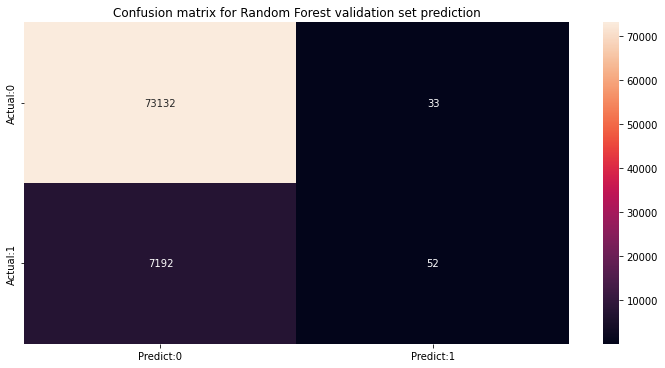

In [72]:
from ift6758.metrics import plot_metrics

#exp.log_figure(
"Confusion Matrix",plot_metrics.plotConfusion(y_valid,y_pred_valid, title='Confusion matrix for Random Forest validation set prediction')#)

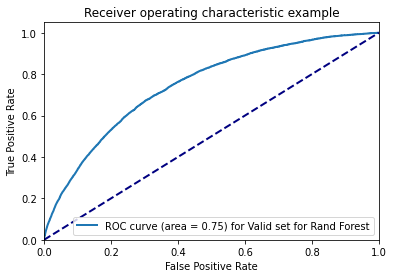

In [73]:
plot_metrics.plot_roc([y_valid],[y_proba_val],["Valid set for Rand Forest"])

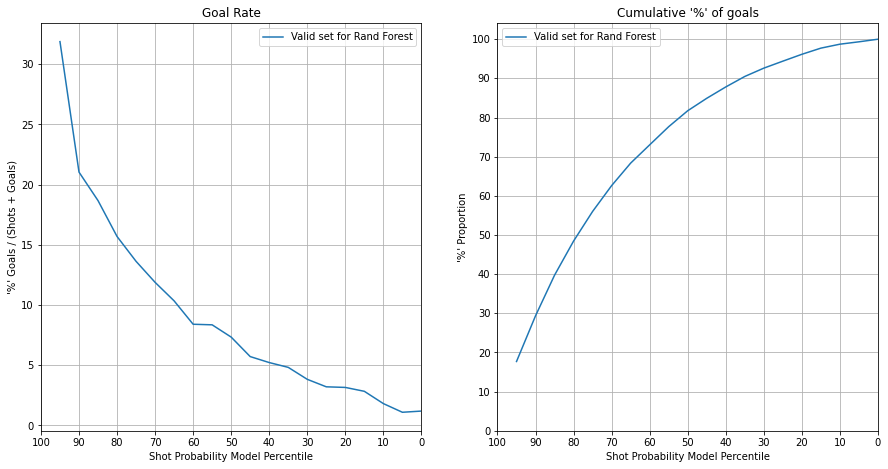

In [74]:
plot_metrics.plot_percentile([y_valid],[y_proba_val],bin_width=5,plot_labels=["Valid set for Rand Forest"])

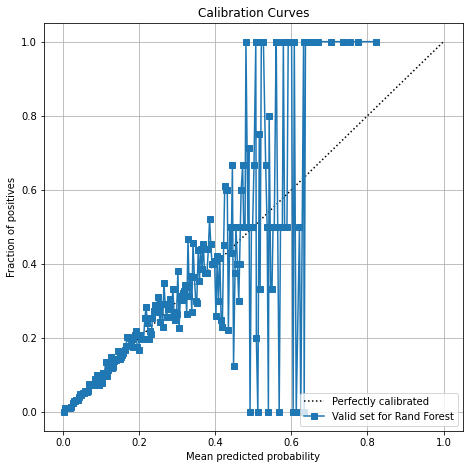

In [75]:
plot_metrics.plot_calibration([y_valid],[y_proba_val],plot_labels=["Valid set for Rand Forest"])

### after I dl the img, export them on Comet

In [ ]:
exp.log_image("figures/roc.png",name="ROC with validation set")

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=40416214fcc94006b0ab97bf72e15a30&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': '40416214fcc94006b0ab97bf72e15a30',
 'web': 'https://www.comet.ml/api/image/download?imageId=40416214fcc94006b0ab97bf72e15a30&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

In [ ]:
exp.log_image("figures/percentile.png",name="Percentile with validation set")
exp.log_image("figures/calibration.png",name="Calibrationn figure with validation set")

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=b42f7c346b204ca5be7f6a361d82f7a0&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': 'b42f7c346b204ca5be7f6a361d82f7a0',
 'web': 'https://www.comet.ml/api/image/download?imageId=b42f7c346b204ca5be7f6a361d82f7a0&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

# On test sets (regular and playoff)

In [76]:
pred_regular  = model.predict(X_test_regular)
proba_regular = model.predict_proba(X_test_regular)[:,1] # get the proba of having a goal (pred=1)
score_regular = model.score(X_test_regular,y_test_regular)
score_regular

0.9076484947111473

In [ ]:
exp.log_metric("Test score on Regular Season", score_regular)

NameError: ignored

In [77]:
pred_playoff  = model.predict(X_test_playoff)
proba_playoff = model.predict_proba(X_test_playoff)[:,1] # get the proba of having a goal (pred=1)
score_playoff = model.score(X_test_playoff,y_test_playoff)
score_playoff

0.9141245834401436

In [ ]:
exp.log_metric("Test score on Playoffs (2019)", score_playoff)

NameError: ignored

## Export model

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-test-regular-with-FE2"
predscore_val_dict={}

In [ ]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_test_reg_label']=y_test_regular
predscore_val_dict[experiment]['proba']=proba_regular
predscore_val_dict[experiment]['prediction']=pred_regular

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-test-regular-with-FE2.pkl']

In [ ]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-test-playoff-with-FE2"
predscore_val_dict={}

import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_test_reg_label']=y_test_playoff
predscore_val_dict[experiment]['proba']=proba_playoff
predscore_val_dict[experiment]['prediction']=pred_playoff

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-test-playoff-with-FE2.pkl']

In [ ]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=1467cfb3eeea4364a6f6ad97d4c06463&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'assetId': '1467cfb3eeea4364a6f6ad97d4c06463',
 'web': 'https://www.comet.ml/api/asset/download?assetId=1467cfb3eeea4364a6f6ad97d4c06463&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

# Plot

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     60194
           1       0.77      0.01      0.02      6172

    accuracy                           0.91     66366
   macro avg       0.84      0.50      0.49     66366
weighted avg       0.90      0.91      0.86     66366

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7139
           1       0.35      0.01      0.02       663

    accuracy                           0.91      7802
   macro avg       0.63      0.50      0.49      7802
weighted avg       0.87      0.91      0.88      7802



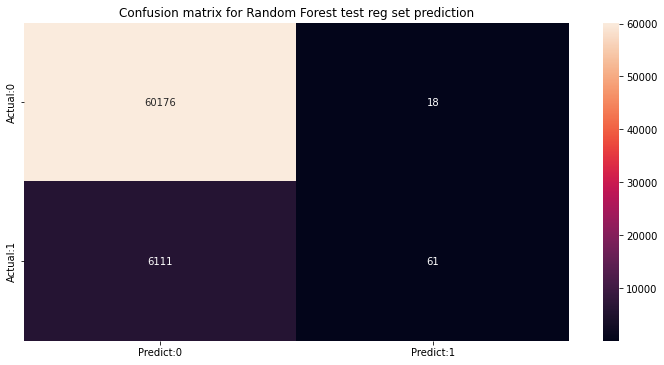

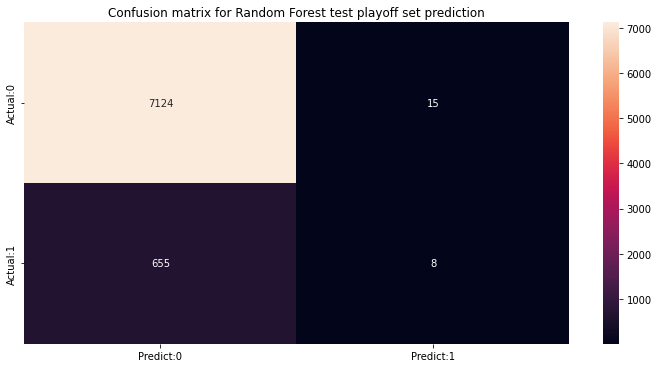

In [78]:
from ift6758.metrics import plot_metrics

#exp.log_figure("Confusion Matrix for regular season test set",
plot_metrics.plotConfusion(y_test_regular,pred_regular, title='Confusion matrix for Random Forest test reg set prediction')#)
#exp.log_figure("Confusion Matrix for playoff season test set", 
plot_metrics.plotConfusion(y_test_playoff,pred_playoff, title='Confusion matrix for Random Forest test playoff set prediction')#)

In [79]:
label_list = [y_test_regular, y_test_playoff]
proba_list = [proba_regular,proba_playoff]
pred_list = [pred_regular,pred_playoff]
title_list = ["Regular Season", "Playoff"]

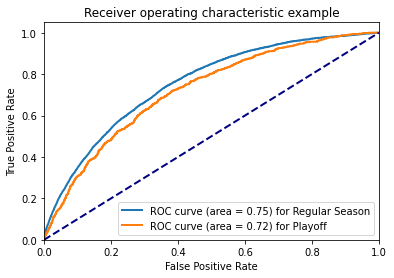

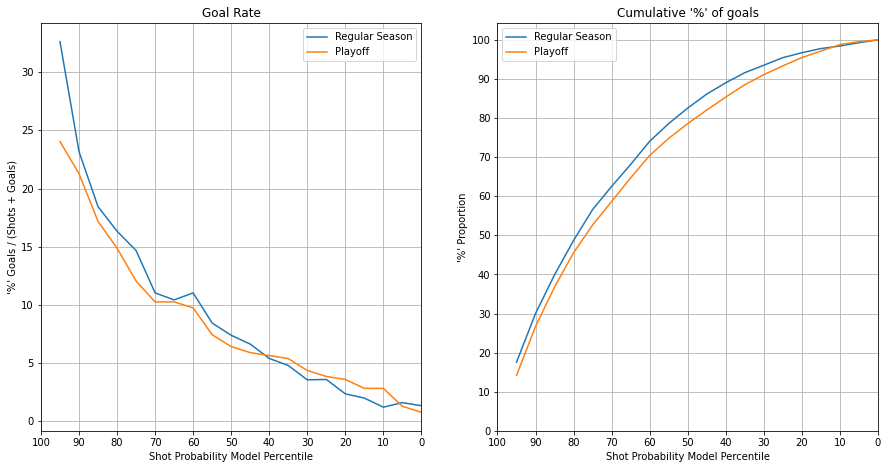

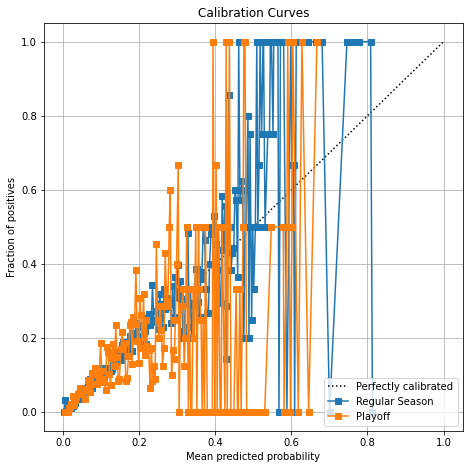

In [80]:
plot_metrics.plot_roc(label_list,proba_list,title_list)
plot_metrics.plot_percentile(label_list,proba_list,bin_width=5,plot_labels=title_list)
plot_metrics.plot_calibration(label_list,proba_list,plot_labels=title_list)

In [ ]:
exp.log_image("figures/roc_test.png",name="Percentile with test set")
exp.log_image("figures/percentile_test.png",name="Percentile with test set")
exp.log_image("figures/calibration_test.png",name="Calibrationn figure with test set")

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=004e84d8139c406785ffe8ddbe25643b&experimentKey=e63f825c8ea044f5becbd0755d4bee36',
 'imageId': '004e84d8139c406785ffe8ddbe25643b',
 'web': 'https://www.comet.ml/api/image/download?imageId=004e84d8139c406785ffe8ddbe25643b&experimentKey=e63f825c8ea044f5becbd0755d4bee36'}

In [ ]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/e63f825c8ea044f5becbd0755d4bee36
COMET INFO:   Metrics:
COMET INFO:     Accuracy on valid (2018) set  : 0.907068000191415
COMET INFO:     Test score on Playoffs (2019) : 0.9148936170212766
COMET INFO:     Test score on Regular Season  : 0.9070457764517976
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FM0rph3e%2Fift6758-project-main%2Fblob%2Fmain%2Fnotebooks%2Ftry_your_best_shot.ipynb
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : 1
COMET INFO:     criterion                : entropy
COMET INFO:     max_depth                : 12
COME